# Poisson-Zero Hidden Markov Model

## Summary

The following exposition uses [`pymc3-hmm`](https://github.com/AmpersandTV/pymc3-hmm) to both simulate and estimate a hidden Markov model (HMM) with emissions consisting of a Poisson random variable and the point at zero.

In [1]:
import numpy as np

import theano
import theano.tensor as tt

import pymc3 as pm

from pymc3_hmm.utils import compute_steady_state
from pymc3_hmm.distributions import SwitchingProcess, DiscreteMarkovChain
from pymc3_hmm.step_methods import FFBSStep, TransMatConjugateStep

## Introduction

Our observation model can be described as follows:

\begin{align}
  \label{eq:pois-zero-model}
  Y_t &= S_t \epsilon_t,\quad
  \epsilon_t \sim \operatorname{Pois}\left( \mu \right)
  \\
  S_t &\sim \operatorname{Bern}\left( \pi_t \right)
  \;,
\end{align}
where $y_t \sim Y_t$ are the observed values sampled from the observation distribution, $Y_t$, spanning $t \in \left\{0, \dots, T \right\}$.

The "hidden" state sequence, $\{S_t\}$, is driven by the following Markov relationship:

\begin{equation*}
    \operatorname{P}\left(S_t \mid S_{t-1}\right) \triangleq \Gamma_{t,t-1} \in \mathbb{R}^{2 \times 2}_{[0, 1]}
\end{equation*}

The marginal state probability, $\pi_t$, is then given by

\begin{equation*}
  \begin{aligned}
    \operatorname{P}\left( S_t \right)
    &= \int_{S_{t-1}} \operatorname{P}\left(S_t \mid S_{t-1}\right)
    \operatorname{dP}\left(S_{t-1}\right)
    \\
    &=
    \begin{pmatrix}
      \Gamma^{(0, 0)}_{t,t-1} & \Gamma^{(0, 1)}_{t,t-1}
      \\
      \Gamma^{(1, 0)}_{t,t-1} & \Gamma^{(1, 1)}_{t,t-1}
    \end{pmatrix}^\top
    \begin{pmatrix}
      \pi_{t-1}
      \\
      1 - \pi_{t-1}
    \end{pmatrix}
    \\
    &=
      \begin{pmatrix}
      \pi_{t}
      \\
      1 - \pi_{t}
    \end{pmatrix}
  \;.
  \end{aligned}
\end{equation*}

Our model is effectively a zero-inflated Poisson with a simple first-order Markov process as the mixing distribution.


In the remainder of this exposition, we will assume Dirichlet priors for each row of $\Gamma_{t, t-1}$, the conjugate Gamma prior for $\mu$, and the steady-state value of $\Gamma_{t, t-1}$ for $\pi_0$.

## Simulation

In [2]:
def create_poisson_zero_hmm(mu, observed, p_0_a=np.r_[5, 1], p_1_a=np.r_[3, 5]):

    p_0_rv = pm.Dirichlet("p_0", p_0_a)
    p_1_rv = pm.Dirichlet("p_1", p_1_a)

    P_tt = tt.stack([p_0_rv, p_1_rv])
    P_rv = pm.Deterministic("P_t", tt.shape_padleft(P_tt))

    pi_0_tt = compute_steady_state(P_rv)

    S_rv = DiscreteMarkovChain("S_t", P_rv, pi_0_tt, shape=np.shape(observed)[-1])
    S_rv.tag.test_value = np.array(observed > 0, dtype=np.int32)

    Y_rv = SwitchingProcess(
        "Y_t", [pm.Constant.dist(0), pm.Poisson.dist(mu)], S_rv, observed=observed
    )

    return Y_rv


In [3]:
np.random.seed(2032)

mu_true = 5000

with pm.Model() as sim_model:
    _ = create_poisson_zero_hmm(mu_true, np.zeros(10000))

sim_point = pm.sample_prior_predictive(samples=1, model=sim_model)
sim_point["Y_t"] = sim_point["Y_t"].squeeze()

y_t = sim_point["Y_t"]

## Estimation

We will use the "true" data-generating observation model to estimate the parameters $\mu$ and $\Gamma_{t, t-1}$ (the latter as rows denoted by `p_0` and `p_1`).  For demonstration purposes, we choose hyper-parameters for the $\mu$ prior that are "far" from the true $\mu$ value.

The sampling steps for $S_t$ are performed using forward-filtering backward-sampling (FFBS).  The steps for $\Gamma_{t, t-1}$ are conjugate samples conditional on the sampled state sequence $\{S_t\}$ provided by FFBS.  Both of these step methods are available in `pymc3-hmm`.

While $\mu$ could also be sampled exactly using a conjugate step&mdash;conditional on $\{S_t\}$&mdash;we instead sample this parameter using PyMC3's built-in NUTS.

In [4]:
with pm.Model() as test_model:
    E_mu, Var_mu = 1000.0, 10000.0
    mu_rv = pm.Gamma("mu", E_mu ** 2 / Var_mu, E_mu / Var_mu)

    _ = create_poisson_zero_hmm(mu_rv, y_t, p_0_a=np.r_[1, 1], p_1_a=np.r_[1, 1])

with test_model:
    transmat_step = TransMatConjugateStep(test_model.P_t)
    states_step = FFBSStep([test_model.S_t])
    mu_step = pm.NUTS([test_model.mu])

    posterior_trace = pm.sample(
        step=[transmat_step, states_step, mu_step],
        return_inferencedata=True,
        chains=1,
        progressbar=True,
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>TransMatConjugateStep: [p_0, p_1]
>FFBSStep: [S_t]
>NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 530 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Posterior Samples

<ipython-input-5-088fcfc0dc0b>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


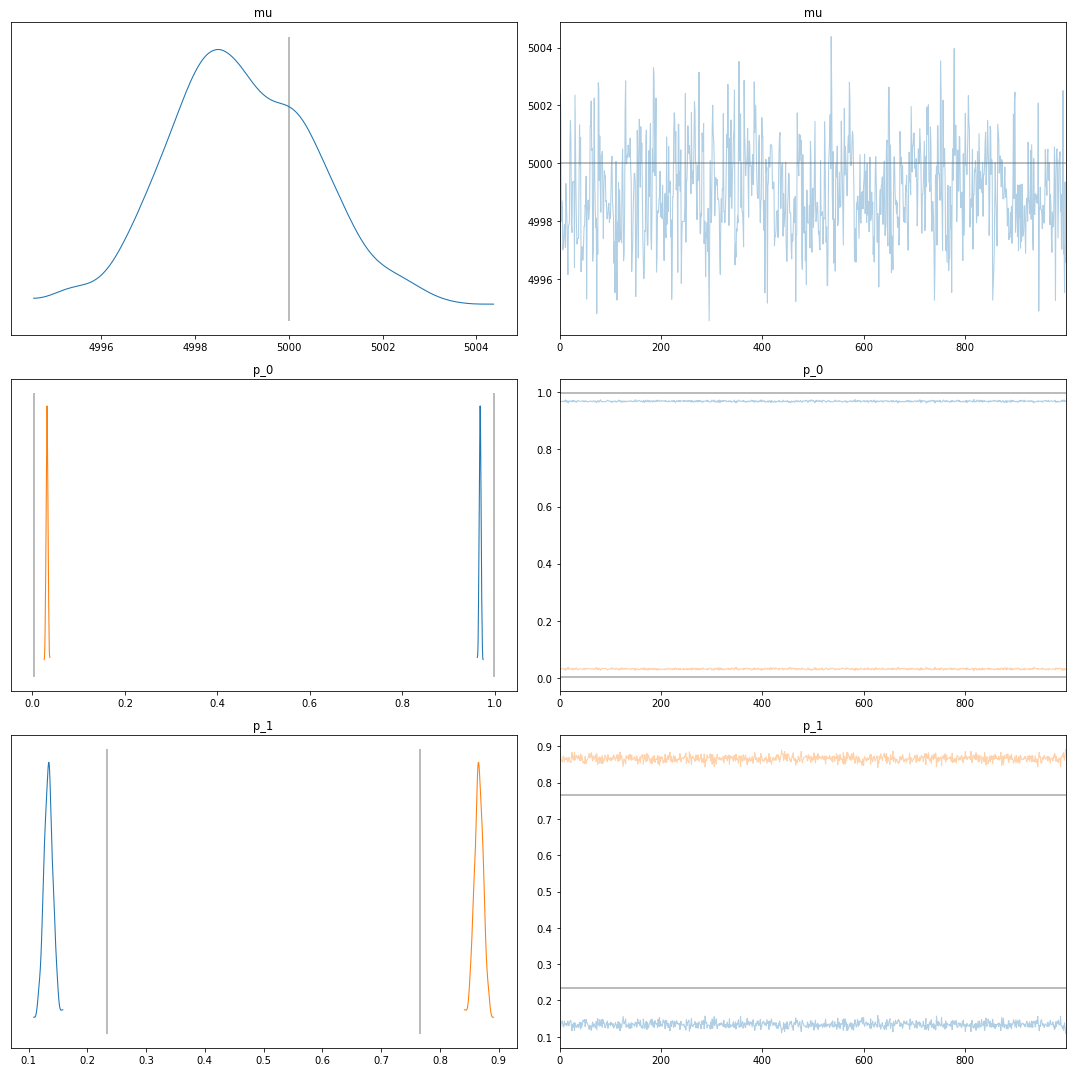

In [5]:
import matplotlib.pyplot as plt

import arviz as az


ax = az.plot_trace(
    posterior_trace.posterior,
    var_names=[
        "mu",
        "p_0",
        "p_1",
    ],
    lines=[
        ("mu", {}, [mu_true]),
        ("p_0", {}, [sim_point["p_0"]]),
        ("p_1", {}, [sim_point["p_1"]]),
    ],
    compact=True,
    figsize=(15, 15),
)

plt.tight_layout()

## Posterior Predictive Samples

In [6]:
with test_model:
    posterior_pred_trace = pm.sample_posterior_predictive(
        posterior_trace.posterior, var_names=["S_t", "Y_t"]
    )

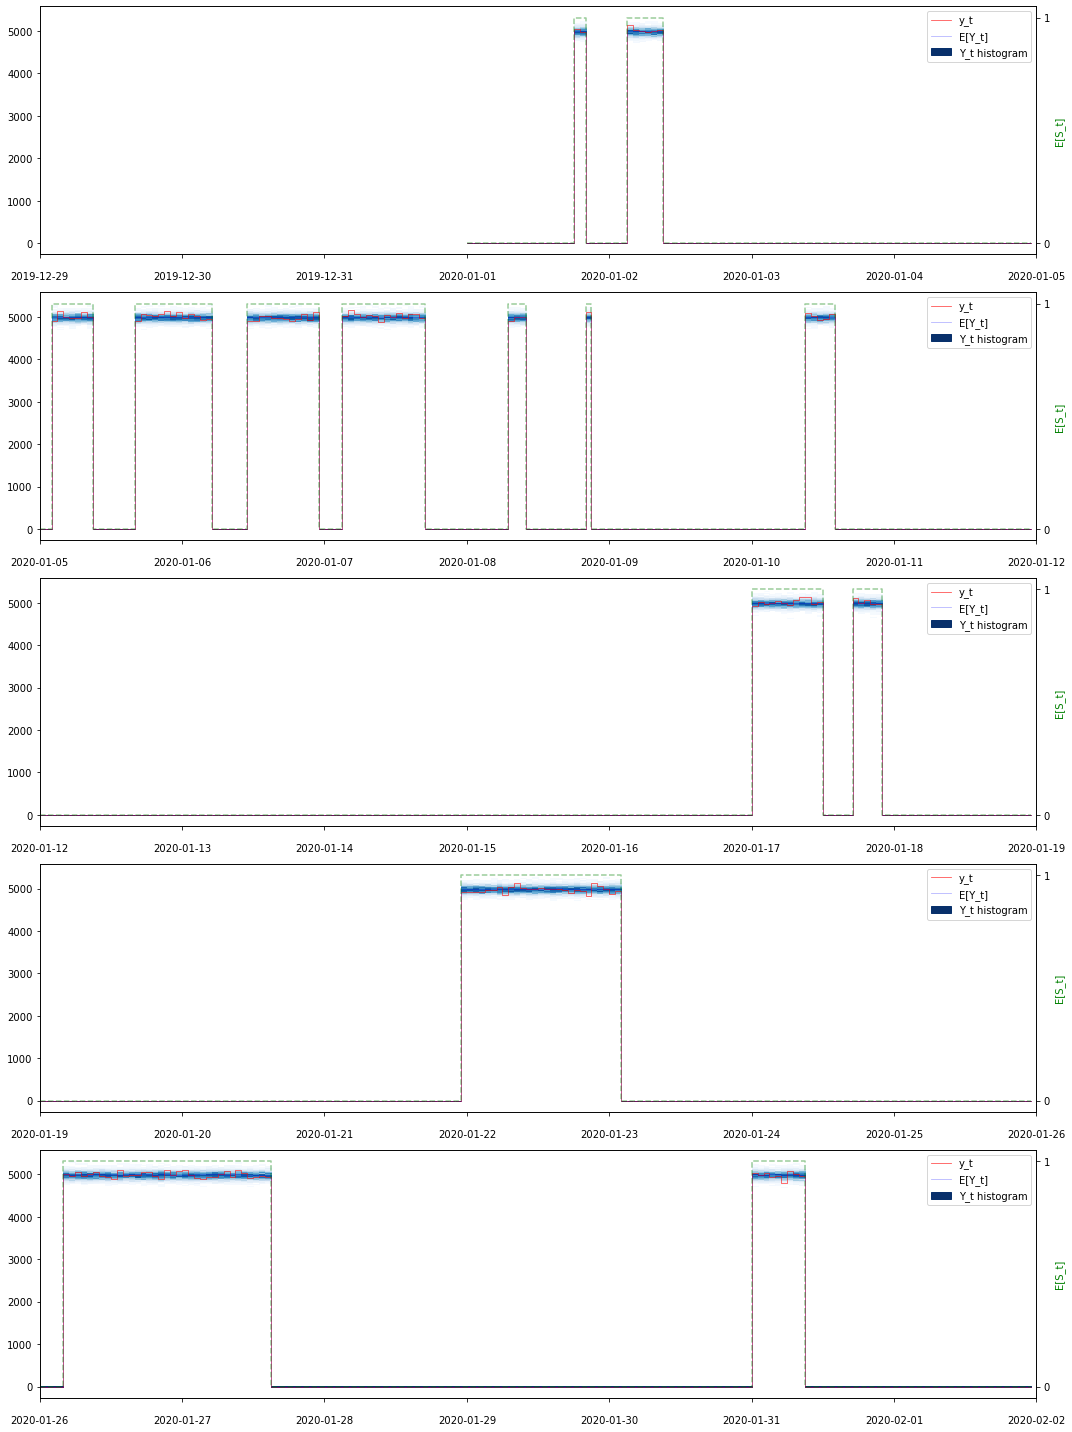

In [7]:
columns = pd.MultiIndex.from_tuples(
    [("Y_t", i) for i in range(posterior_pred_trace["Y_t"].shape[0])],
    names=("var", "sample"),
)

plot_data = pd.DataFrame(
    posterior_pred_trace["Y_t"].T,
    index=time_index,
    columns=columns,
)
plot_data["E[S_t]"] = posterior_pred_trace["S_t"].mean(0)
plot_data["E[Y_t]"] = posterior_pred_trace["Y_t"].mean(0)
plot_data["y_t"] = y_t


def plot_fn(ax, data, **kwargs):
    ax.plot(
        data["y_t"],
        label="y_t",
        alpha=0.7,
        color="red",
        linewidth=0.8,
        drawstyle="steps",
    )

    ax.plot(
        data["E[Y_t]"],
        label="E[Y_t]",
        alpha=0.3,
        color="blue",
        linewidth=0.8,
        drawstyle="steps",
    )

    plot_predictive_histograms(data["Y_t"], axes=ax)


axes_split_data = plot_split_timeseries(
    plot_data,
    split_max=10,
    twin_column_name="E[S_t]",
    twin_plot_kwargs={
        "color": "green",
        "drawstyle": "steps",
        "linestyle": "--",
        "alpha": 0.4,
    },
    figsize=(15, 30),
    plot_fn=plot_fn,
)

for (_, twin_ax), _ in axes_split_data:
    _ = twin_ax.set_ylabel("E[S_t]", color=twin_ax.get_lines()[0].get_color())
    _ = twin_ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

## Out-of-sample Posterior Predictives

In [8]:
with test_model, theano.config.change_flags(compute_test_value="off"):

    test_model.S_t.distribution.shape = (24 * 7,)

    out_of_sample_pp = pm.sample_posterior_predictive(
        posterior_trace.posterior.drop_vars("S_t"),
        var_names=["S_t", "Y_t"],
        model=test_model,
    )

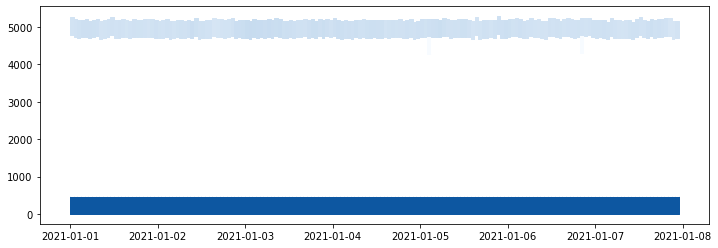

In [9]:
columns = pd.MultiIndex.from_tuples(
    [("Y_t", i) for i in range(out_of_sample_pp["Y_t"].shape[0])],
    names=("var", "sample"),
)

out_of_sample_data = pd.DataFrame(
    out_of_sample_pp["Y_t"].T,
    index=pd.date_range(
        start="1/1/2021", periods=out_of_sample_pp["Y_t"].shape[1], freq="H"
    ),
    columns=columns
)
out_of_sample_data[("mean", 0)] = out_of_sample_pp["Y_t"].mean(0)


ax = plot_predictive_histograms(out_of_sample_data["Y_t"])